# Imports

### Libraries

In [ ]:
# TensorFlow and tf.keras
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

print(tf.__version__)

2.4.0


### Dataset

In [ ]:
# Download the mnist dataset
mnist = tf.keras.datasets.mnist

# Load the dataset into '_raw' varible: They'll need further processing.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Custom functions

In [ ]:
def pprint_numpy_matrix(mat, fmt="g"):
    """Pretty print a numpy matrix"""

    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]

    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")


# Exploratory data analysis

**Get the types of the variables**

In [ ]:
print("X_train", type(X_train))
print("y_train", type(y_train))

X_train <class 'numpy.ndarray'>
y_train <class 'numpy.ndarray'>


**Shapes**

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

The train data are 60 000 images of 28x28 pixels, labeled.

**Target**

In [ ]:
y_train[0]

5

The target are a 60 000 array. Each entry contain the number corresponfing to the image.

### Display the images

About the images we'll be training on:
- Each one is 28 pixels by 28 pixels, and totally black and white.
- The 28 rows and 28 columns of numbers in the training data correspond to the 28 rows and 28 columns of pixels in the image.
- The darkness of each pixel is represented as a number in the training data, where 0 is a white pixel and 255 is a black pixel. 

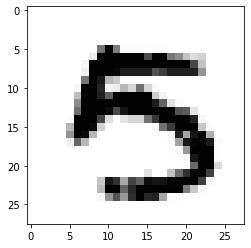

This image represents the number 5


In [ ]:
# index can goes from 0 to 59 999
index = 1526

# Plot the image
plt.imshow(X_train[index], cmap='Greys', interpolation='nearest')
plt.show()

# Print the image label
print('This image represents the number', y_train[index])

Print the numpy matrix

In [ ]:
pprint_numpy_matrix(X_train[index])

0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    0    1  158  255  151    7    7    7    4    7    7    2    0    0    0    0    0   0  0  0  0  
0  0  0  0  0    0    0    1   37  253  253  253  253  253  253  196  253  253  156  136   89   59   71    0   0  0  0  0  
0  0  0  0  0    0    0   19  253  253  253  253  253  253  253  253  253  253  253  253  253  199   88    0   0  0  0  0  
0  0  0 

# Cleaning

### Target categorical encoding

In [ ]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

Check categorical encoding:

In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

### Reshape the features

As described here: https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc

2D convolutional layers need inputs at least as:
 - if using channels_last: (batch_size, imageside1, imageside2, channels)
 - if using channels_first: (batch_size, channels, imageside1, imageside2)

So, in this case, our 2Dconv layer need a 4-dim input of (None, width, height, channel). Currently, we have only a (None, width, height) input. Let's create a 4th empty dimenstion:

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

### Cast features to float32

Faster training time when dtype is float32

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

### Features rescaling

Resclate the features images from 0x255, to 0x1

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Check if the rescaling occurred correctly

print("min", X_train[index].min())
print("max", X_train[index].max())

min 0.0
max 1.0


# Model creation

In [ ]:
def create_model():

  # Init a sequential model
  model = keras.Sequential([
    

    # Part 1: Feature detector
    # --------------------------------------------------------------------------

    # First VGG block
    # Hidden layer 1: 32 filters, 3x3 kernel, relu activation function
    layers.Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    # Hidden layer 2: 32 filters, 3x3 kernel, relu activation function
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),


    # Second VGG block
    # Hidden layer 3: 64 filters, 3x3 kernel, relu activation function
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    # Hidden layer 4: 64 filters, 3x3 kernel, relu activation function
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),


    # Third VGG block
    # Hidden layer 5: 128 filters, 3x3 kernel, relu activation function
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    # Hidden layer 6: 128 filters, 3x3 kernel, relu activation function
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),

    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),


    # Part 2: classifier
    # --------------------------------------------------------------------------

    # Simple ANN
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),


    # Output layer
    layers.Dense(10, activation='softmax')

  ])

  # Compile model 
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])

  return model

Create the model on the GPU

In [ ]:
with tf.device('/device:GPU:0'):
  model = create_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1

### Dataset augmentation

API: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=360)

In [ ]:
datagen.fit(X_train)

In [ ]:
augmented_train = datagen.flow(X_train, y_train, batch_size=64)

In [ ]:
steps = int(X_train.shape[0] / 64)

with tf.device('/device:GPU:0'):
  history = model.fit_generator(augmented_train, steps_per_epoch=steps, epochs=200, validation_data=(X_test,y_test), shuffle=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
937/937 [==============================] - 25s 23ms/step - loss: 1.8098 - accuracy: 0.4361 - val_loss: 0.3045 - val_accuracy: 0.9053
Epoch 2/200
937/937 [==============================] - 21s 23ms/step - loss: 0.5067 - accuracy: 0.8334 - val_loss: 0.2620 - val_accuracy: 0.9113
Epoch 3/200
937/937 [==============================] - 21s 22ms/step - loss: 0.3704 - accuracy: 0.8820 - val_loss: 0.1738 - val_accuracy: 0.9449
Epoch 4/200
937/937 [==============================] - 21s 22ms/step - loss: 0.3154 - accuracy: 0.9006 - val_loss: 0.1981 - val_accuracy: 0.9343
Epoch 5/200
937/937 [==============================] - 21s 22ms/step - loss: 0.2718 - accuracy: 0.9128 - val_loss: 0.1545 - val_accuracy: 0.9463
Epoch 6/200
937/937 [==============================] - 21s 23ms/step - loss: 0.2515 - accuracy: 0.9206 - val_loss: 0.1539 - val_accuracy: 0.9453
Epoch 7/200
937/937 [==============================] - 22s 23ms/step - loss: 0.2406 - accuracy: 0.9239 - val_loss: 0.1394 - val_ac

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 97.81%


In [ ]:
width, height, *_ = X_train[0].shape
example = X_train[0].reshape(1, width, height, 1)

In [ ]:
model.predict(example)

array([[8.7719663e-06, 1.6161330e-05, 6.6036795e-05, 3.9591165e-03,
        4.8596361e-03, 9.7946852e-01, 1.2501853e-03, 9.7255921e-03,
        4.8106565e-05, 5.9799373e-04]], dtype=float32)

# Model evaluation

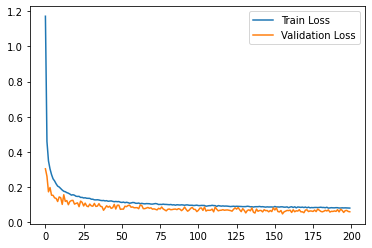

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

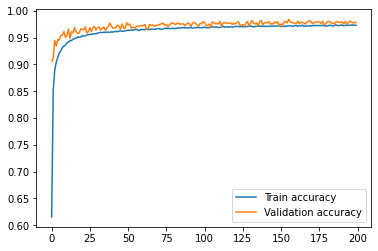

In [ ]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

# Model exportation

In [ ]:
model.save('mnist_cnn_model.h5')